# QGraphs - A quantum model for digraph representation and navigation

*This notebook explores creation and use of* ***QGgraphs (Quantum Digraphs)*** *in* ***Networkx+PennyLane+PyTorch**.*

**By:** Jacob Cybulski<br>
**Date:** August 2024<br>
**Aims:** The goal of this notebook is to test some *Quantum Digraph (QGraphs)* features and functions.<br/>
**Refs:**
- Brownlee, J., 2019. <a href="https://machinelearningmastery.com/divergence-between-probability-distributions/" target="_blank">How to Calculate the KL Divergence for Machine Learning</a>. MachineLearningMastery.com.
- <a href="https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence" target="_blank">Kullback–Leibler divergence</a>, Wikipedia.
- <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a>, Wikipedia.
- <a href="https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html" target="_blank">KLDivLoss</a>. PyTorch docs.

**PennyLane technical refs:**
- https://pennylane.ai/codebook/
- https://docs.pennylane.ai/en/stable/index.html
- https://docs.pennylane.ai/en/stable/introduction/interfaces.html (see refs to Fourier and fun fitting examples below)
- https://docs.pennylane.ai/en/stable/code/api/pennylane.qnn.TorchLayer.html (see ref to an example below)
- https://pytorch.org/docs/stable/optim.html
- Example of circuit building: https://pennylane.ai/qml/demos/tutorial_learning_few_data/
- Example of circuit building: https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series/
- Example of training: https://pennylane.ai/qml/demos/function_fitting_qsp/
- Example of creating Torch nn layer: https://pennylane.ai/qml/demos/tutorial_qnn_module_torch/

**PyTorch technical refs:**
- Initialise weights: https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch
- First NN in PyTorch: https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
- PyTorch training loop: https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/

## What are QGraphs

A *QGraph* is a weighted directed graph, which excludes parallel edges (in the same direction), but allowing loops. It defines a stochastic navigation between its verteces, where the probability of taking a particular edge from a given vertex is given by the edge weight.

Formally, a qgraph $G$ is defined as a weighted digraph:

$$G = \{V, E, w\},$$

where $V = \{v\}$ is a set of digraph vertices, $E = \{(v_s,v_t) : v_s, v_t \in V\}$ is a set of directional edges, and $|V|$ being the number of vertices in $V$.<br/>
Function $w(V, V)\rightarrow R$ assigns weights to all edges, such that:

$$w(v_s, v_t) =
\left\{
	\begin{array}{ll}
		p(v_t | v_s)  & \forall_{v_s, v_t \in V,\;(v_s, v_t) \in E}\\
		0 & \forall_{v_s, v_t \in V,\;(v_s, v_t) \notin E}
	\end{array}
\right.
$$

where $p(v_t | v_s)$ is the probability of navigating over the edge $(v_s, v_t)$ when arrived at the source vertex $v_s$ to its target $v_t$ (including the self), and:

$$\forall_{(v_s, v_t) \in E}\: \sum_{v_t} w(v_s, v_t) = 1.$$

This means that every digraph vertex must have at least one outgoing link.

An arbitrary weighted digraph $G = \{V, E, w(V, V)\}$ can be expanded to become a QGraph $G^{'} = \{V^{'}, E^{'}, w^{'}(V^{'}, V^{'})\}$ by adding loops to all verteces $v$ with outdegree 0, and rescaling weights to add up to 1. Now:

$$\forall_{v \in V}\; v \in V^{'} \land \forall_{e \in E}\; e \in E^{'}$$
$$\forall_{v_s \in V}\;(\forall_{v_t \in V}\;(v_s, v_t) \notin E) \Longrightarrow (v_s, v_s) \in E^{'} \land w^{'}(v_s, v_s) = 1$$
$$\forall_{(v_s, v_t) \in E}\; w^{'}(v_s, v_t) = \frac{w(v_s, v_t)}{\sum_{(v_s, v_i) \in E}\; w(v_s, v_i)}$$

## PennyLane Implementation

A QGraph $G = \{V, E, w\}$, with $v \in V$ as the vertex unique numeric identifier, represents a parameterised function $f_\theta(V) \rightarrow V$,
which can be realised as a quantum circuit $U(v, \theta)$ measured projectively with observable $\mathcal{M}$:

$$
\begin{gather}
    f_\theta(v) = tr[ \mathcal{M} U(v, \theta)^\dagger \vert 0 \rangle \langle 0 \vert U(v, \theta) ],\quad and\\
    U(v, \theta) = A(\theta)S(v).
\end{gather}
$$

$S(v)$ is a feature map and $A(\theta)$ an ansatz with trainable parameters $\theta = (\theta_0, \theta_1, ..., \theta_n)$.
The ansatz can be trained on the graph edges $e = (v_s, v_t) \in E$ and their weights $w(v_s, v_t)$, such that $v_s$ would be passed as the input to $U(v, \theta)$, which is subsequently executed repeatedly to produce a distribution of possible outcomes $v_t$, each approximating the probability $p(v_t|v_s)$ aimed to approach the value of its edge weight $w(v_s, v_t)$.

The circuit $U(v, \theta)$ training can be facilitated by running $U(v_s, \theta)$ repeatedly for each vertex $v_s$ and measuring the difference between two probability distributions of possible paths from vertex $v_s$, i.e. the observed probability distribution $P(v_s) = \{p(v_t | v_s) : \forall_{v_t \in V}\}$ and the expected distribution $W(v_s) = \{w(v_s, v_t) : \forall_{e=(v_s, v_t) \in E}\}$. 
The standard loss function that could support the model training is $L1$, which would measure the distance between pairs of probability distributions $W(v_s)$ and $P(v_s)$. As the size of $P(v_s)$ distribution cannot be predicted in advance, hence the computational complexity of the $L1(W(v_s), P(v_s))$ measurement would be $O({\vert V \vert}^2)$.
The entire cost would then be measured as $MAE(W, P)$ with the complexity of $O({\vert V \vert}^3)$.

A more suitable loss function could be *Kullback-Leibler Divergence*, stated as a function $KL(W(v_s) || P(v_s))$ representing the magnitude of our "surprise" when the model adopts the observed distribution $P(v_s)$ instead of the actual distribution $W(v_s)$. The $KL$ loss function for the vertex $v_s$ can be defined as follows (adapted from Brownlee 2019):

$$KL(W(v_s) || P(v_s)) = \sum_{(v_s, v_t) \in E} w(v_s, v_t) * log(w(v_s, v_t) / p(v_t | v_s))$$

Therefore, the cost (average loss) of differences between observed and expected navigations for all digraph vertices is:

$$
\begin{array}{ll}
    KL(W || P) 
    &=&\frac{1}{|V|}\sum_{v_s \in V}\;KL(W(v_s) || P(v_s))\\
    &=&\frac{1}{|V|}\sum_{v_s \in V}\sum_{(v_s, v_t) \in E}\; w(v_s, v_t) * log(w(v_s, v_t) / p(v_t | v_s)) \\
    &=&\frac{1}{|V|}\sum_{(v_s, v_t) \in E}\; w(v_s, v_t) * log(w(v_s, v_t) / p(v_t | v_s))
\end{array}
$$

For the $KL$ function to be computable, we only consider pairs of vertices $(v_s, v_t)$ that have non-zero weights $w(v_s, v_t)$ and non-zero probability $p(v_t | v_s)$. 
Also note that $KL$ ignores those vertex pairs which emerge as "probably navigable" during model training, but not actually connected by an edge, meaning their pairwise weight is zero. 
This leads to the more selective cost calculation, with its complexity to be $O(|V||E|)$, with the upper bound of $O(|V|^3)$, however significantly lower for sparse graphs.

*Kullback-Leibler Divergence* is not symmetrical, i.e. $KL(W || P) \neq KL(P || W)$, and tends to generate very large negative values. Therefore, a related *Jensen-Shannon Divergence* could be used as a replacement. $JS$ loss function can be defined as follows (adapted from Brownlee 2019):

$$
\begin{array}{ll}
    &&\text{the loss function is:}\\
    \\
    &&for\; M(v_s) = 0.5\; (W(v_s) + P(v_s)),\\
    JS(W(v_s) || P(v_s)) 
    &=&0.5 * KL(W(v_s) || M(v_s)) + 0.5 * KL(P(v_s) || M(v_s)),\\
    \\
    &&\text{and the cost (average loss) is:}\\
    \\
    &&for\; M = 0.5\; (W + P),\\
    JS(W || P) 
    &=&\frac{1}{|V|}\sum_{v_s \in V}\;JS(W(v_s) || P(v_s))\\
    &=&0.5 * \frac{1}{|V|}\sum_{v_s \in V}\;(KL(W(v_s) || M(v_s)) + KL(P(v_s) || M(v_s))) \\
    &=&0.5 * (\frac{1}{|V|}\sum_{v_s \in V}\;KL(W(v_s) || M(v_s)) + \frac{1}{|V|}\sum_{v_s \in V}\;KL(P(v_s) || M(v_s))) \\
    &=&0.5 * (KL(W || M) + KL(P || M))
\end{array}
$$

As noted by Brownlee (2019), when compared with KL divergence, $JS(W(v_s) || P(v_s))$, and consequently $JS(W || P)$, is a more useful measure for model training - it is smooth and normalized, and, when using the base-2 logarithm, its scores are in the range from 0 (identical) to 1 (maximally different). Its computational complexity is also $O(|V||E|)$.

Note that in PyTorch, the class <a href="https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html" target="_blank">KLDivLoss</a> (see examples) defines the KL function, which takes as its arguments *input* (P), which is the result produced by a model (e.g. NN), and a *target* (W) which defines observations drawn from the data.

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/pl-039/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-039/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-039/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-039/lib/python3.11/site-packages',
 '.']

In [2]:
### General libraries

import matplotlib.pyplot as plt
import matplotlib.patches as pltpat
import pylab
import copy
import math
import os
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

In [3]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp

# Pytorch imports
import torch
from torch import nn, tensor, optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

jax.config.update("jax_enable_x64", True)

In [4]:
# Import local utilities

from utils.Circuits import *
from utils.Charts import *
from utils.Digraphs import *
from utils.Files import *
from utils.PennyLane import *

## Define log details

In [5]:
### Constants
LOG_NAME = 'logs'
CASE_NAME = 'bench'
DATA_NAME = 'rand'
GRAPH_PATH = f'{LOG_NAME}/graph'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH = f'{LOG_NAME}/training'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Create a folder if needed
create_folder_if_needed(GRAPH_PATH)
create_folder_if_needed(FIGURES_PATH)
create_folder_if_needed(TRAIN_PATH)
create_folder_if_needed(ANALYSIS_PATH)

### Show constants
{'LOG_NAME': LOG_NAME, 'CASE_NAME': CASE_NAME, 'DATA_NAME': DATA_NAME, 'GRAPH_PATH': GRAPH_PATH, 
  'FIGURES_PATH': FIGURES_PATH, 'TRAIN_PATH': TRAIN_PATH, 'ANALYSIS_PATH': ANALYSIS_PATH}

{'LOG_NAME': 'logs',
 'CASE_NAME': 'bench',
 'DATA_NAME': 'rand',
 'GRAPH_PATH': 'logs/graph',
 'FIGURES_PATH': 'logs/figures',
 'TRAIN_PATH': 'logs/training',
 'ANALYSIS_PATH': 'logs/analysis'}

## Load the digraph

Loaded graph from file: logs/graph/digraph_016_025_v011_wei.json


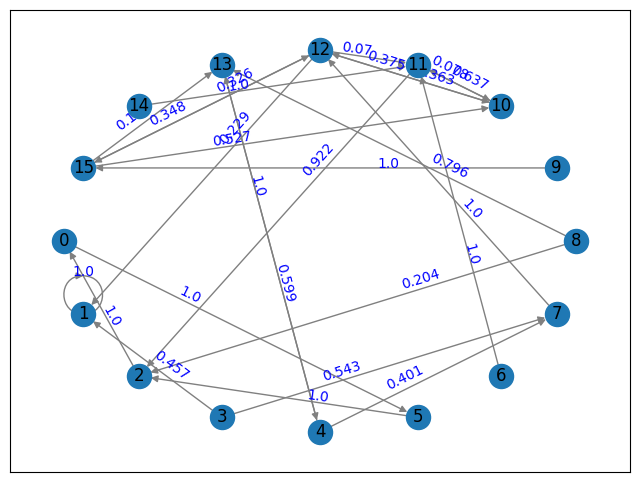

In [6]:
### Loading a graph from a file
G_ID = '016_025_v011'
G_path = f'{GRAPH_PATH}/digraph_{G_ID}_wei.json'
G = load_digraph(G_path)
draw_weighted_digraph(G, 'weight', ax=None)
print(f'Loaded graph from file: {G_path}')

In [7]:
G_dets = digraph_details(G)
n_vertices = len(G_dets['nodes'])
n_edges = len(G_dets['links'])
display(G_dets)
print(f'\nNumber of vertices: {n_vertices}, Number of edges = {n_edges}\n')

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 0},
  {'id': 1},
  {'id': 2},
  {'id': 3},
  {'id': 4},
  {'id': 5},
  {'id': 6},
  {'id': 7},
  {'id': 8},
  {'id': 9},
  {'id': 10},
  {'id': 11},
  {'id': 12},
  {'id': 13},
  {'id': 14},
  {'id': 15}],
 'links': [{'weight': 1.0, 'source': 0, 'target': 5},
  {'weight': 1.0, 'source': 1, 'target': 1},
  {'weight': 1.0, 'source': 2, 'target': 0},
  {'weight': 0.45699699778175795, 'source': 3, 'target': 1},
  {'weight': 0.5430030022182419, 'source': 3, 'target': 7},
  {'weight': 0.40118645596188407, 'source': 4, 'target': 7},
  {'weight': 0.598813544038116, 'source': 4, 'target': 13},
  {'weight': 1.0, 'source': 5, 'target': 2},
  {'weight': 1.0, 'source': 6, 'target': 11},
  {'weight': 1.0, 'source': 7, 'target': 12},
  {'weight': 0.20382662551202604, 'source': 8, 'target': 2},
  {'weight': 0.7961733744879739, 'source': 8, 'target': 13},
  {'weight': 1.0, 'source': 9, 'target': 15},
  {'weight': 0.636960655317765


Number of vertices: 16, Number of edges = 26



## QGraph training parameters

In [8]:
n_data = int(np.ceil(np.log2(n_vertices)))
n_extra = 1
n_wires = n_data+n_extra
n_layers = 3
rot = 'Rxyz'
mode = 'hybrid'

iters = 10
epochs = 2000
log_interv = 10
scaler = np.pi
shots = 1000 # ignored for state vector
seed = 2024
thr = 0.05 # Optimum to br determined

### Define devices

In [9]:
### Find what devices are available

# Type to be used with tensors
dtype = torch.float64
torch.set_default_dtype(dtype)

# Quantum simulator
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\nThe optimum devices: {sim} and {torch_device}')

# Force CPU to avoid moving computation and data back and from the GPU
torch_device = "cpu"

print(f'Devices to be used:  {sim} and {torch_device}\n')


The optimum devices: default.qubit and cpu
Devices to be used:  default.qubit and cpu



### Jensen-Shannon Divergence

Refs: 
- Amin Jun + Renly Hou, <a href="https://discuss.pytorch.org/t/jensen-shannon-divergence/2626/9" target="_blank">JSD implementation</a>, pytorch.org
- johnball, <a href="https://stats.stackexchange.com/questions/303735/jensen-shannon-divergence-for-multiple-probability-distributions">Multiple JSD implementation</a>, stackexchange.com


In [10]:
### KL and JSD divergence metrics
#   All metrics arguments follow the order according to the PyTorch convention
#   - P: obtained output
#   - W: expected targets
class div_metrics(nn.Module):
    def __init__(self):
        super(div_metrics, self).__init__()

    # KL cost function, assumes equal shapes of W and P
    # Removes all (w, p) pairs which have zeros
    # - P: obtained output
    # - W: expected targets
    def kl(self, P: torch.tensor, W: torch.tensor):
        vn = W.shape[0]
        W, P = torch.flatten(W), torch.flatten(P)
        kl = sum([w * math.log2(w / p) for (w, p) in zip(W, P) if (w > 0) and (p > 0)]) / vn
        return kl

    # JSD cost function, assumes equal shapes of W and P
    # Removes all (w, p) pairs which have zeros
    # - P: obtained output
    # - W: expected targets
    def jsd(self, P: torch.tensor, W: torch.tensor):
        M = 0.5 * (W + P)
        jsd = 0.5 * (self.kl(M, W) + self.kl(M, P))
        return jsd

    # JSD loss function (so a single vertex data)
    def jsd_single_loss(self, outputs: torch.tensor, targets: torch.tensor):
        self.jsd(torch.tensor([outputs]), torch.tensor([targets]))

In [11]:
### Testing KL and JSD metrics
#   Assumes data to be multiple vertices

# d1 = torch.Tensor([[0.1, 0.3, 0.1, 0.4, 0.1], [0.0, 0.0, 0.3, 0.5, 0.1]])
# d2 = torch.Tensor([[0.0, 0.2, 0.3, 0.3, 0.2], [0.1, 0.1, 0.3, 0.5, 0.0]])
# d3 = torch.Tensor([[0.0, 0.0, 0.0, 0.9, 0.1], [0.4, 0.4, 0.0, 0.0, 0.2]])
# d4 = torch.Tensor([[0.0, 1.0], [1.0, 0.0]])
# d5 = torch.Tensor([[1.0, 0.0], [0.0, 1.0]])

# m = div_metrics()
# print(f'kl(d1, d1) = {m.kl(d1, d1)}')
# print(f'kl(d1, d2) = {m.kl(d1, d2)}')
# print(f'kl(d2, d1) = {m.kl(d2, d1)}')
# print(f'kl(d1, d3) = {m.kl(d1, d3)}')
# print(f'kl(d3, d1) = {m.kl(d3, d1)}\n')

# print(f'jsd(d1, d1) = {m.jsd(d1, d1)}')
# print(f'jsd(d1, d2) = {m.jsd(d1, d2)}')
# print(f'jsd(d2, d1) = {m.jsd(d2, d1)}')
# print(f'jsd(d1, d3) = {m.jsd(d1, d3)}')
# print(f'jsd(d3, d1) = {m.jsd(d3, d1)}')
# print(f'jsd(d4, d5) = {m.jsd(d5, d4)}')

### Utilities

In [12]:
### Counts the number of purely pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Gets all pytorch parameters
def get_param_vals(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    params = params.cpu().detach().flatten() # [0]
    return params.numpy()

In [13]:
### Converts a list/array of numbers to a list of their binary representations as a list
def nums_to_bin_tensor(num_list, n_data, torch_device='cpu'):
    bin_list_list = np.array([bin_int_to_list(n, n_data) for n in num_list])
    tens_list = torch.tensor(bin_list_list, dtype=torch.double)
    return tens_list.to(torch_device)

### Test
# nums_to_bin_tensor([1, 3, 6, 7], 4)

### Prepare data for QGraph training

In [14]:
### Convert the graph to its adjacency matrix
adj_mat = digraph_to_adjmat(G)

### Prepare X and Y vectors for training
X = nums_to_bin_tensor(range(adj_mat.shape[0]), n_data, torch_device=torch_device)
Y = torch.tensor(adj_mat, dtype=torch.double)
X[0:5],Y[0:5]

(tensor([[0., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 1.],
         [0., 1., 0., 0.]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4570, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5430, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4012, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.5988, 0.0000, 0.0000]]))

### Create and Test a QGraph Quantum Circuit

The qgraph circuit will be a simple QNN. A few different approaches will be tested as determined by the input encoding.
- Simple encoding, with each vertex mapped into a qubit - requires $|V|$ qubits
- Basis encoding, with each vertex number mapped into a binary qubit representation - requires $log_2(|V|)$ qubits

In [15]:
### QGraph wrapper with a static data structure and variant input and weights only
#   wires: circuit wires
#   n_data: number of data wires to be reserved
#   n_extra: number of extra wires to be used in training
#   n_layers: number of entangling layers to be produced
#   rot: rotation type, either 'Ry' or 'Rxyz'
#   scaler: scaler to be applied to the inputs
def qgraph_basis(wires, n_data, n_extra, n_layers=1, rot='Ry', scaler=np.pi):
    
    def _qgraph_circ(inputs, weights):
        # inputs: A single number, being a scaled (down) vertex id
        #         Note that when a NN generates inputs, its results will be in range [-1..1]
        # output: probability distribution of applying the circuit shot number of times
        nonlocal wires, n_data, n_extra, n_layers, rot, scaler
        
        n_learn = n_data + n_extra
        data_wires = wires[0:n_data]
        learn_wires = wires[0:n_learn]
        scaled_inputs = torch.mul(inputs, scaler)
        qml.AngleEmbedding(scaled_inputs, wires=data_wires)
        
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=learn_wires)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=learn_wires)
        # return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]
        return qml.probs(wires=data_wires)
    return _qgraph_circ

def qgraph_basis_shape(n_data, n_extra, n_layers=1, rot='Ry'):
    n_wires = n_data + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        shape = (0)
    return shape

In [16]:
### Create a test model

shape = qgraph_basis_shape(n_data, n_extra, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)

vertex = nums_to_bin_tensor([5], n_data, torch_device=torch_device)
vertices = nums_to_bin_tensor([2, 3, 6, 7], n_data, torch_device=torch_device)
weights = torch.rand(shape, requires_grad=True)

print(f'QGraph shape: {shape}, Epochs: {epochs}, Shots: {shots}, Seed: {seed}, Mode: {mode}')

QGraph shape: (3, 5, 3), Epochs: 2000, Shots: 1000, Seed: 2024, Mode: hybrid


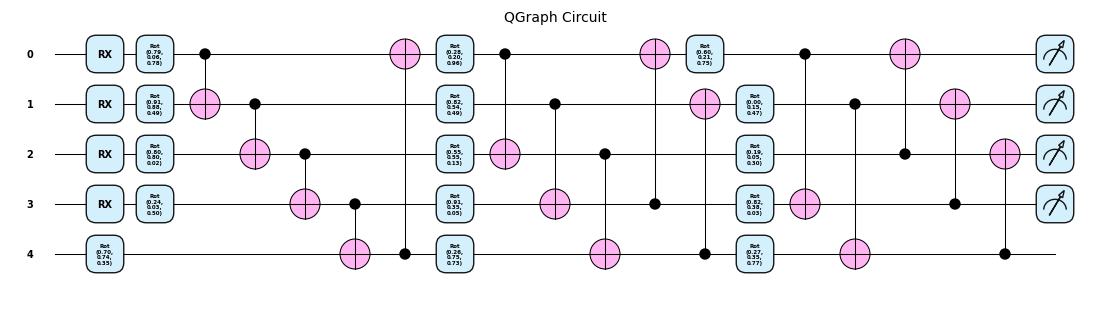

In [17]:
### Testing QGraph for training

# Define a static QGraph
qgraph = qgraph_basis(range(n_wires), n_data, n_extra, n_layers=n_layers, rot=rot, scaler=scaler)

# Create and draw a QGraph circuit
dev = qml.device(sim, wires=n_wires, shots=shots)
qgraph_qc = qml.QNode(qgraph, dev, interface='torch') #, level='gradient')
dc = draw_circuit(qgraph_qc, scale=0.5, title='QGraph Circuit', level='device') # device # gradient
dc(vertex, weights) # expansion_strategy='device'/'gradient'

In [18]:
###### Test the circuit
probs = qgraph_qc(vertices, weights)
print(f'\nParameters: Scaler={np.round(scaler, 4)}, n_data={n_data}\n')
print(f'Inputs:\n{vertices}\n')
print(f'Weights {weights.detach().numpy().shape}: \n{weights}\n')
print(f'Outputs: probability distributions=\n{probs}\nsum(probs)={[np.round(sum(p).item(), 3) for p in probs]}\n')


Parameters: Scaler=3.1416, n_data=4

Inputs:
tensor([[0., 0., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 1., 0.],
        [0., 1., 1., 1.]])

Weights (3, 5, 3): 
tensor([[[7.8540e-01, 6.0549e-02, 7.7568e-01],
         [9.0893e-01, 8.8342e-01, 4.8964e-01],
         [7.9593e-01, 7.9860e-01, 1.6298e-02],
         [2.3907e-01, 3.3394e-02, 4.9901e-01],
         [7.0373e-01, 7.4125e-01, 3.5151e-01]],

        [[2.8486e-01, 2.0212e-01, 9.5579e-01],
         [8.2183e-01, 5.4254e-01, 4.9490e-01],
         [5.5356e-01, 5.4614e-01, 1.2962e-01],
         [9.0966e-01, 3.4674e-01, 5.0791e-02],
         [2.5725e-01, 7.5387e-01, 7.2744e-01]],

        [[5.9778e-01, 2.0886e-01, 7.4846e-01],
         [3.3473e-04, 1.4511e-01, 4.7079e-01],
         [1.8585e-01, 5.2181e-02, 3.0088e-01],
         [8.1941e-01, 3.7822e-01, 2.9257e-02],
         [2.7288e-01, 3.5420e-01, 7.6685e-01]]], requires_grad=True)

Outputs: probability distributions=
tensor([[0.1120, 0.4300, 0.0060, 0.0210, 0.0090, 0.0270, 0.0

## Create and Test QGraph Trainable Model
The generated model can be Classical / Quantum / Hybrid

In [19]:
##### Hybrid QGraph
#
#   Graph properties:
#      wires: circuit wires
#      n_data: number of data wires to be reserved
#      n_extra: number of extra wires to be used in training
#      n_layers: number of entangling layers to be produced
#      rot: rotation type, either 'Ry' or 'Rxyz'
#      scaler: scaler to be applied to all inputs
#      mode: QGraph type, i.e. 'classic', 'quantum' or 'hybrid'
#
#   Circuit functionality (input -> output):
#      input - vertex id (log2N qubits)
#      output - edge weight distribution / probability distribution of target vertex selection (N results)
class qgraph_model(nn.Module):

    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_model, self).__init__()

        self.qg_mode = 'q'
        self.sim = sim
        self.n_data = n_data
        self.n_extra = n_extra
        self.n_wires = n_data+n_extra
        self.wires = list(range(n_wires))
        self.n_layers = n_layers
        self.rot = rot
        self.shots = shots
        self.scaler = scaler

        # Create the model
        def_qlayer = self.qlayer()
        layers = self.layers(def_qlayer)        
        self.model = nn.Sequential(*layers)  

    ### Define an optional (default) quantum layer
    def qlayer(self):
        # Define QGraph circuit weight shapes
        tensor_shape = qgraph_basis_shape(self.n_data, self.n_extra, n_layers=self.n_layers, rot=self.rot)
        weights_shapes = {"weights": tensor_shape}
        init_method = {"weights": torch.rand(tensor_shape, requires_grad=True)} # torch.nn.init.normal_ # torch.nn.init.uniform_

        # Define QGraph circuit and its layer
        qgraph = qgraph_basis(self.wires, self.n_data, self.n_extra, n_layers=self.n_layers, rot=self.rot, scaler=self.scaler)
        if self.shots == 0:
            dev = qml.device(self.sim, wires=self.n_wires)
        else:
            dev = qml.device(self.sim, wires=self.n_wires, shots=self.shots)
        qgraph_node = qml.QNode(qgraph, dev, interface='torch') #, diff_method='spsa') #, level='gradient')
        qlayer = qml.qnn.TorchLayer(qgraph_node, weight_shapes=weights_shapes, init_method=init_method)
        return qlayer
        
    ### Define all qgraph layers and return their list
    def layers(self, qlayer):
        ### Default only a quantum layer
        return [qlayer]

    ### Set or return the qgraph mode (any string)
    def mode(self, vmode=None):
        if vmode is not None:
            self.qg_mode = vmode
        return self.qg_mode

    ### Apply the model to data
    def forward(self, x):
        x = self.model(x)
        return x

#####
##### Several subclassess to illustrate how to vary the model
#####

class qgraph_classic_8(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_classic_8, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('c8')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        clayer_0 = torch.nn.Linear(self.n_data, self.n_data)
        clayer_1 = torch.nn.ReLU()
        clayer_2 = torch.nn.Linear(self.n_data, 20)
        clayer_3 = torch.nn.ReLU()
        clayer_4 = torch.nn.Linear(20, self.n_data)
        clayer_5 = torch.nn.Linear(self.n_data, 2**self.n_data)
        
        layers = [clayer_0, clayer_1, clayer_2, clayer_3, clayer_4, clayer_5]
        return layers

class qgraph_classic_8_softmax(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_classic_8_softmax, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('cs8')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        clayer_0 = torch.nn.Linear(self.n_data, self.n_data)
        clayer_1 = torch.nn.ReLU()
        clayer_2 = torch.nn.Linear(self.n_data, 20)
        clayer_3 = torch.nn.ReLU()
        clayer_4 = torch.nn.Linear(20, self.n_data)
        clayer_5 = torch.nn.Linear(self.n_data, 2**self.n_data)
        
        layers = [clayer_0, clayer_1, clayer_2, clayer_3, clayer_4, clayer_5]
        return layers

    def forward(self, x):
        x = self.model(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

class qgraph_quantum_8(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_quantum_8, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('q8')

    def layers(self, qlayer):        
        layers = [qlayer]
        return layers

class qgraph_hybrid_8(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_hybrid_8, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('hs8')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        clayer_0 = torch.nn.Linear(self.n_data, self.n_data)
        clayer_1 = torch.nn.ReLU()
        clayer_2 = torch.nn.Linear(self.n_data, 20)
        clayer_3 = torch.nn.ReLU()
        clayer_4 = torch.nn.Linear(20, self.n_data)
        
        layers = [clayer_0, clayer_1, clayer_2, clayer_3, clayer_4, qlayer]
        return layers

class qgraph_classic_16(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_classic_16, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('c16')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        slayer_0 = torch.nn.Linear(self.n_data, 50)
        slayer_1 = torch.nn.ReLU()
        slayer_2 = torch.nn.Linear(50, 100)
        slayer_3 = torch.nn.ReLU()
        slayer_4 = torch.nn.Linear(100, 50)
        slayer_5 = torch.nn.ReLU()
        slayer_6 = torch.nn.Linear(50, self.n_data)
        slayer_7 = torch.nn.Linear(50, 2**self.n_data)
        
        layers = [slayer_0, slayer_1, slayer_2, slayer_3, slayer_4, slayer_5, slayer_7]
        return layers

class qgraph_classic_16_softmax(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_classic_16_softmax, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('cs16')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        slayer_0 = torch.nn.Linear(self.n_data, 50)
        slayer_1 = torch.nn.ReLU()
        slayer_2 = torch.nn.Linear(50, 100)
        slayer_3 = torch.nn.ReLU()
        slayer_4 = torch.nn.Linear(100, 50)
        slayer_5 = torch.nn.ReLU()
        slayer_6 = torch.nn.Linear(50, self.n_data)
        slayer_7 = torch.nn.Linear(50, 2**self.n_data)
        
        layers = [slayer_0, slayer_1, slayer_2, slayer_3, slayer_4, slayer_5, slayer_7]
        return layers

    def forward(self, x):
        x = self.model(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

class qgraph_quantum_16(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_quantum_16, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('q16')

    def layers(self, qlayer):        
        layers = [qlayer]
        return layers

class qgraph_hybrid_16(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_hybrid_16, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('h16')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        slayer_0 = torch.nn.Linear(self.n_data, 50)
        slayer_1 = torch.nn.ReLU()
        slayer_2 = torch.nn.Linear(50, 100)
        slayer_3 = torch.nn.ReLU()
        slayer_4 = torch.nn.Linear(100, 50)
        slayer_5 = torch.nn.ReLU()
        slayer_6 = torch.nn.Linear(50, self.n_data)
        
        layers = [slayer_0, slayer_1, slayer_2, slayer_3, slayer_4, slayer_5, slayer_6, qlayer]
        return layers


In [20]:
### Trains QGraph models
#   X: Vertex number (from 0 to max)
#   Y: Array(0..max) of (expected) edge weights to all other vertices (including the self)
#
#   Notes:
#   - To save the model state / parameters
#     torch.save(qgraph.state_dict(), PATH)
#     torch.save(opt_params, PATH)
#   - To load the model state / parameters
#     torch.load(PATH, weights_only=True)
#     qgraph.load_state_dict(opt_params, strict=False)
#   - To check the model state / parmeters
#     qgraph.state_dict()

def train_model(model, lossfun, optimizer, X, Y, epochs=50, log_interv=100, prompt_fract=0.1):
    history = []
    min_epoch = 0
    min_loss = 1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):

        optimizer.zero_grad()
        output = model(X)
        loss = lossfun(output, Y)
        loss.backward()
        optimizer.step()
        
        curr_loss = loss.item()
        if curr_loss < min_loss: 
            min_loss = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if epoch % log_interv == 0:
            history.append(curr_loss)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
            
        running_loss += curr_loss

    return history, opt_params, hist_params, (min_epoch, min_loss)

### Remind the QAE params

In [21]:
print(f'\nModel training hyper-parameters:\n'+
    f'\n'+
    f'G_path = "{G_path}"\n'+
    f'n_vertices = {n_vertices}\n'+
    f'n_edges = {n_edges}\n'+
    f'\n'+
    f'n_layers = {n_layers}\n'+
    f'n_data = {n_data}\n'+
    f'n_extra = {n_extra}\n'+
    f'n_wires = {n_wires}\n'+
    f'rot = "{rot}"\n'+
    # f'mode = "{mode}"\n'+
    f'\n'+
    f'scaler = {scaler}\n'+
    f'shots = {shots}\n'+
    f'seed = {seed}\n'+
    f'epochs = {epochs}\n'+
    f'log_interv = {log_interv}\n'+
    f'')


Model training hyper-parameters:

G_path = "logs/graph/digraph_016_025_v011_wei.json"
n_vertices = 16
n_edges = 26

n_layers = 3
n_data = 4
n_extra = 1
n_wires = 5
rot = "Rxyz"

scaler = 3.141592653589793
shots = 1000
seed = 2024
epochs = 2000
log_interv = 10



## Train the model

In [22]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Test data only
# epochs = 2000
# rot = 'Rxyz'
# log_interv = 10

### Create a model
# qgraph = qgraph_model(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_quantum_8(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_classic_8(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_classic_8_softmax(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_hybrid_8(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_quantum_16(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_classic_16(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_classic_16_softmax(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
qgraph = qgraph_hybrid_16(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)

mode = qgraph.mode()

### Loss and optimiser

lossfun = nn.MSELoss()
# lossfun = nn.L1Loss()
# lossfun = div_metrics().jsd

# optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
optimizer = optim.Adam(qgraph.parameters())

display(qgraph.eval())

qgraph_hybrid_16(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=4, bias=True)
    (7): <Quantum Torch Layer: func=_qgraph_circ>
  )
)

In [23]:
### All created files have the following codes:
#   v: vertices
#   e: edges
#   m: mode = 1st letter of quantum / classic / hybrid
#   n: # of data wires
#   x: # of extra wires
#   lays: # of layers
#   rot: rotation type = Ry / Rxyz
#   ep: # of training epochs

TRAIN_PREF = f'{CASE_NAME}_{DATA_NAME}_v{n_vertices}_e{n_edges}_n{n_data}_x{n_extra}_lays{n_layers}_{rot}_{mode}_ep{epochs}'
TRAIN_PREF

'bench_rand_v16_e26_n4_x1_lays3_Rxyz_h16_ep2000'

In [24]:
### Train the model
start = time.time()

history, opt_params, hist_params, opt_point = \
    train_model(qgraph, lossfun, optimizer, X, Y, epochs=epochs, log_interv=log_interv, prompt_fract=0.05)

elapsed = time.time() - start

# Print run statistics
shape = qgraph_basis_shape(n_data, n_extra, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)

print(f'\n'+
      f'{sim} & {torch_device} Fit ('+
      f'{X.shape[0]} samples, '+
      f'{n_data}+{n_extra}={n_wires} qubits, '+
      f'{n_weights} params, '+
      f'{epochs} epochs): '+
      f'{round(opt_point[1], 5)} min cost @ iter# {opt_point[0]}, '+
      f'{elapsed:0.2f} sec'+
      f'\n'
     )

epoch 0 	 Loss: 0.04866
epoch 100 	 Loss: 0.03281
epoch 200 	 Loss: 0.02828
epoch 300 	 Loss: 0.02548
epoch 400 	 Loss: 0.02106
epoch 500 	 Loss: 0.0162
epoch 600 	 Loss: 0.01424
epoch 700 	 Loss: 0.01337
epoch 800 	 Loss: 0.01291
epoch 900 	 Loss: 0.01266
epoch 1000 	 Loss: 0.01253
epoch 1100 	 Loss: 0.01246
epoch 1200 	 Loss: 0.01242
epoch 1300 	 Loss: 0.0124
epoch 1400 	 Loss: 0.01239
epoch 1500 	 Loss: 0.01238
epoch 1600 	 Loss: 0.01239
epoch 1700 	 Loss: 0.01237
epoch 1800 	 Loss: 0.01237
epoch 1900 	 Loss: 0.01241

default.qubit & cpu Fit (16 samples, 4+1=5 qubits, 45 params, 2000 epochs): 0.01237 min cost @ iter# 1999, 72.49 sec



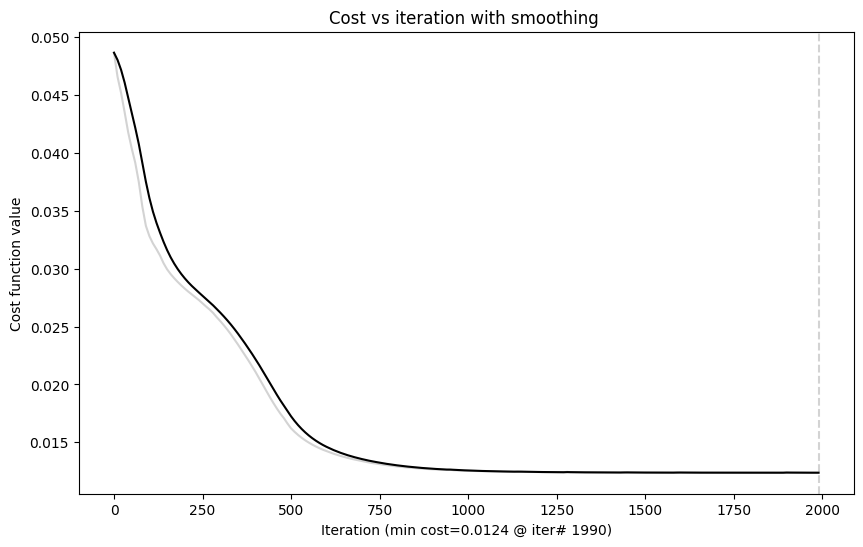

In [25]:
cost_plot(history, rcParams=(10, 6), backplot=True, back_color='lightgray', smooth_weight=0.7, log_interv=log_interv, 
          save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_hist{epochs}.eps')

## Test the model
*Investigate the (lower) weight threshold at which it is considered there is no edge between vertices*

In [26]:
### Apply a metric to (expect, result) pairs, eliminating small values 
###    according to a list of thresholds
def thr_metrics_results(expect, result, thr_list, metric):
    met_vals = []
    for thr in thr_list:
        if type(result) is torch.Tensor:
            opt_result = result.clone()
        else:
            opt_result = result.copy()
        # opt_result = result.copy()
        opt_result[abs(opt_result.real) < thr] = 0.0
        met_val = metric(expect, opt_result)
        met_vals.append(met_val)
    return np.array(met_vals)

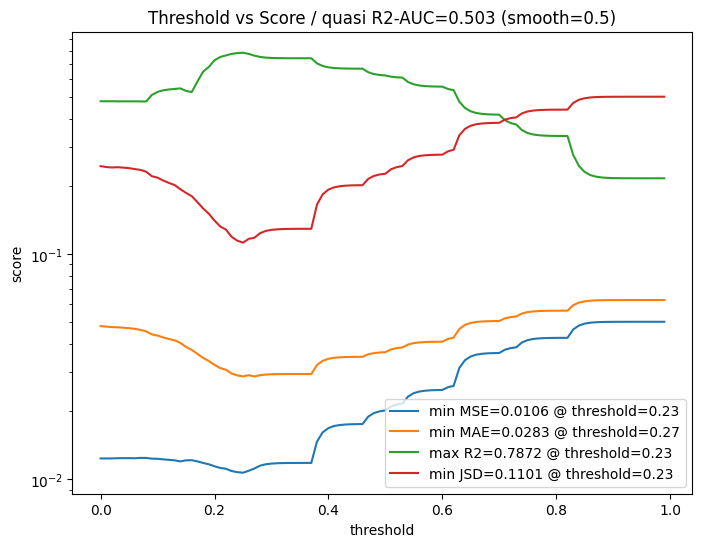

In [27]:
### Calculate threshold vs MSE, MAE, R2, JSD
### Find the optimum threshold and quasi-AUC

from sklearn.metrics import auc, mean_squared_error, mean_absolute_error, r2_score
jsd_score = div_metrics().jsd

### Retrieve expected and observed digraph weights
expect = Y.detach().numpy()
result = qgraph(X).detach().numpy()

### Calculate stats for different threshold levels
thr_dx = 1.0/100
thr_list = np.arange(0.0, 1.0, thr_dx).numpy()
mse_scores = thr_metrics_results(expect, result, thr_list, mean_squared_error)
mae_scores = thr_metrics_results(expect, result, thr_list, mean_absolute_error)
r2_scores = thr_metrics_results(expect, result, thr_list, r2_score)
jsd_scores = thr_metrics_results(torch.tensor(expect), torch.tensor(result), thr_list, jsd_score)

title = f'Threshold vs Score / quasi R2-AUC={np.round(auc(thr_list,r2_scores), 3)}'
multi_perform_plot([mse_scores, mae_scores, r2_scores, jsd_scores], log_interv=[thr_dx]*4,
                   meas_min=[True, True, False, True], labels=['MSE', 'MAE', 'R2', 'JSD'], 
                   title=title, meas_type='score', xlabel='threshold',
                   backplot=False, smooth_weight=0.5, save_plot=None,
                   back_color='linen', line_styles=None, line_cols=None, 
                   rcParams=(8, 6), yscale='log', xlim=None, ylim=None)

In [28]:
### Find the optimum threshold
mse_min = np.min(mse_scores)
mse_min_idx = np.argmin(mse_scores)
opt_thr = thr_list[mse_min_idx]
print(f'Min MSE={np.round(mse_min, 4)} @ thr[{mse_min_idx}]={np.round(opt_thr, 4)}')

Min MSE=0.0106 @ thr[23]=0.23


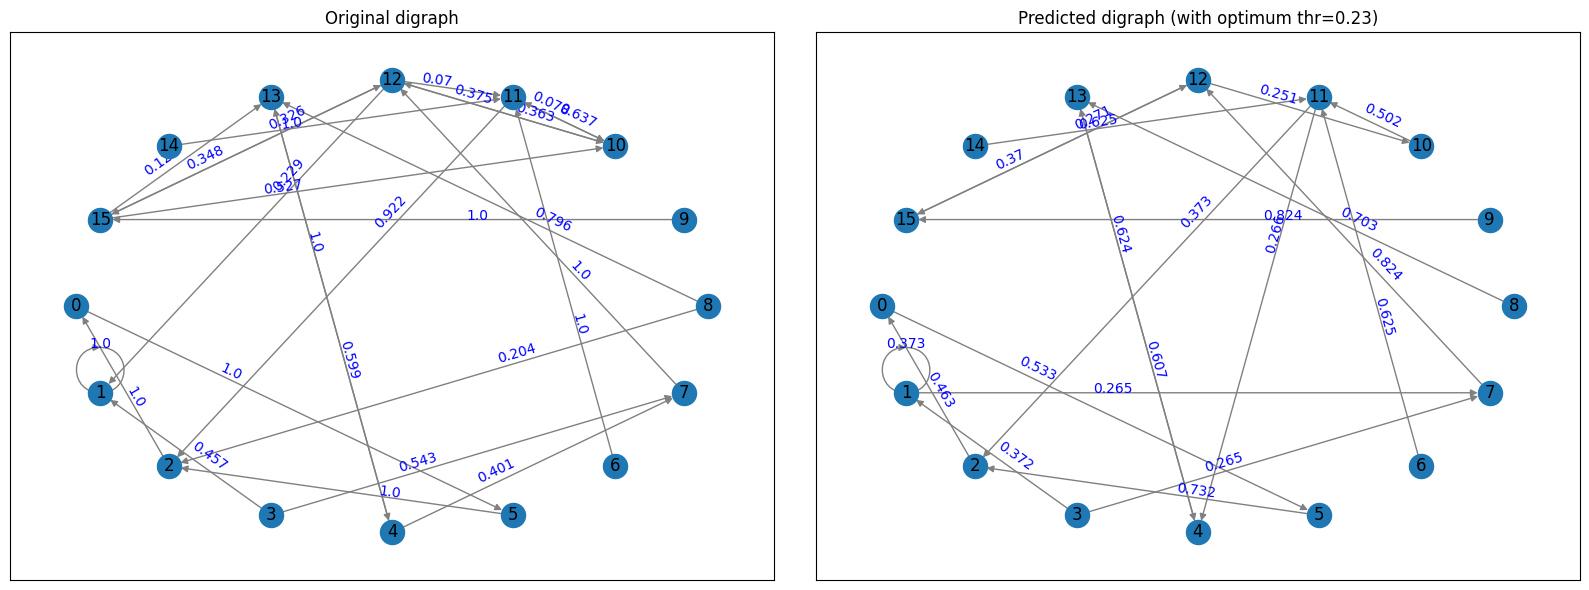

In [29]:
### Find the resulting graph (in relation to the threshold)
opt_result = result.copy()
opt_result[abs(opt_result.real) < opt_thr] = 0.0
res_G = nx.from_numpy_array(opt_result, create_using=nx.DiGraph)

### Compare the original and resulting graph
draw_weighted_digraphs([G, res_G], titles=['Original digraph', f'Predicted digraph (with optimum thr={np.round(opt_thr, 4)})'],
                       attr_name='weight', rcParams=(16, 6), save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_graph{epochs}.eps')

## Analysis of results

In [30]:
### Print statistical scores
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
jsd_score = div_metrics().jsd

print(f'\nScores (original vs predicted) @ optimum thr={opt_thr}\n')
print(f'\tMSE\t= {np.round(mean_squared_error(expect, opt_result), 4)}')
print(f'\tMAE\t= {np.round(mean_absolute_error(expect, opt_result), 4)}')
print(f'\tR2\t= {np.round(r2_score(expect, opt_result), 4)}')
print(f'\tJSD\t= {np.round(jsd_score(torch.tensor(expect), torch.tensor(opt_result)), 4)}')
print(f'\nScores comparing models (all thresholds vs predicted)\n')
print(f'\tR2-AUC\t= {np.round(auc(thr_list,r2_scores), 3)}\n')


Scores (original vs predicted) @ optimum thr=0.23

	MSE	= 0.0106
	MAE	= 0.0283
	R2	= 0.7872
	JSD	= 0.1101

Scores comparing models (all thresholds vs predicted)

	R2-AUC	= 0.503



In [31]:
### Print results
#   From: First columns has the "from" vertext numbers
#   To: First row indicates the "to" vertex numbers
#   exp/res: indicates whether the row represents expected edge weight or its observed probability

# Heading
print(f'{"From:": <5} {"To:": <5}', end='')
for r in range(result.shape[0]):
    print(f'{r:< 8}', end='')
print()

# Rows
for r in range(result.shape[0]):
    row_expects = [f'{np.abs(n):.4f}' for n in expect[r]]
    row_results = [f'{np.abs(n):.4f}' for n in opt_result[r]]
    print(f'{r: <5} exp = {"  ".join(row_expects)}  = {sum(expect[r]): <.4f}')
    print(f'{"": <5} obs = {"  ".join(row_results)}  = {sum(np.abs(opt_result[r])): <.4f}\n')

From: To:   0       1       2       3       4       5       6       7       8       9       10      11      12      13      14      15     
0     exp = 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  = 1.0000
      obs = 0.0000  0.0000  0.0000  0.0000  0.0000  0.5325  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  = 0.5325

1     exp = 0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  = 1.0000
      obs = 0.0000  0.3732  0.0000  0.0000  0.0000  0.0000  0.0000  0.2654  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  = 0.6386

2     exp = 1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  = 1.0000
      obs = 0.4632  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000

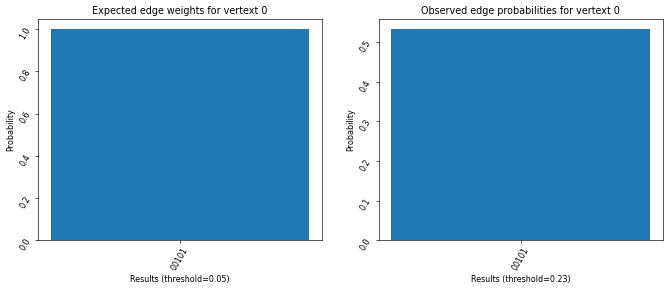

None

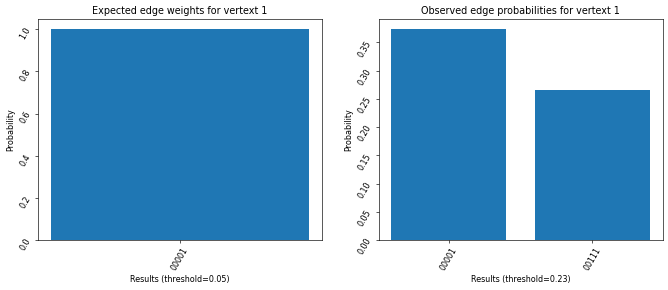

None

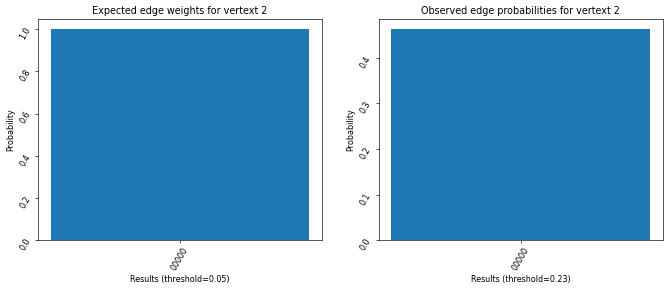

None

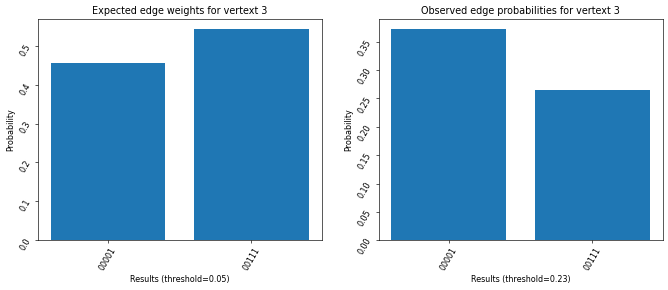

None

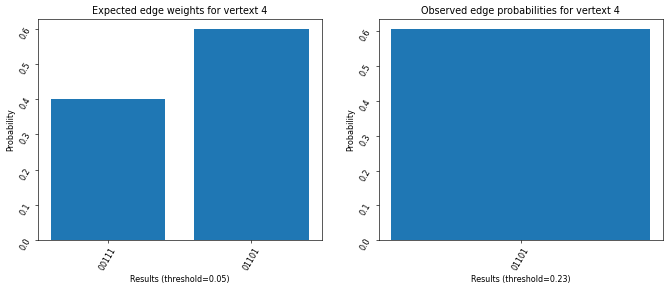

None

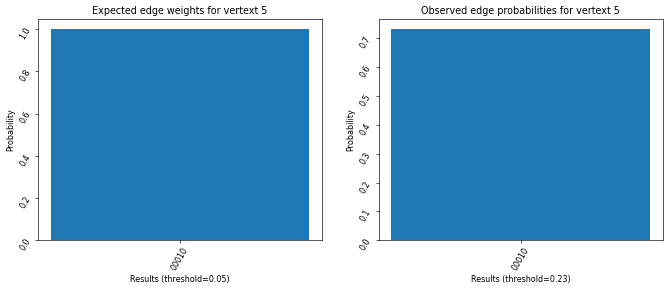

None

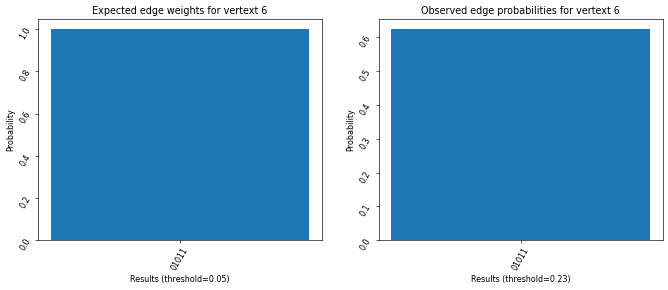

None

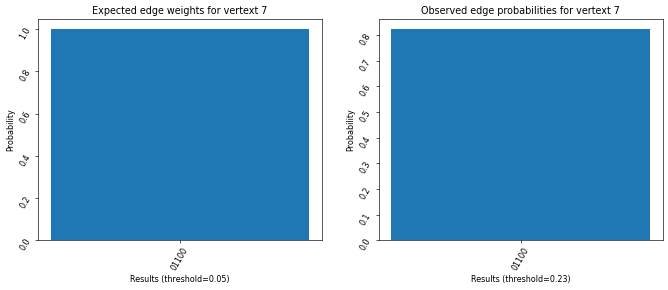

None

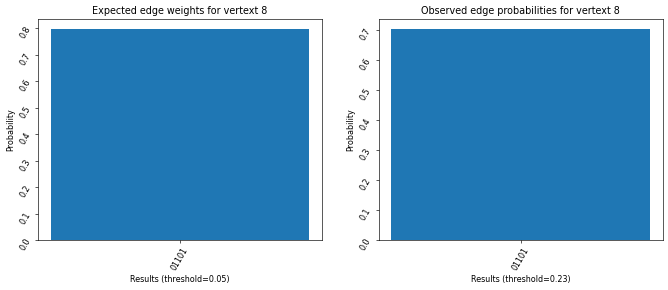

None

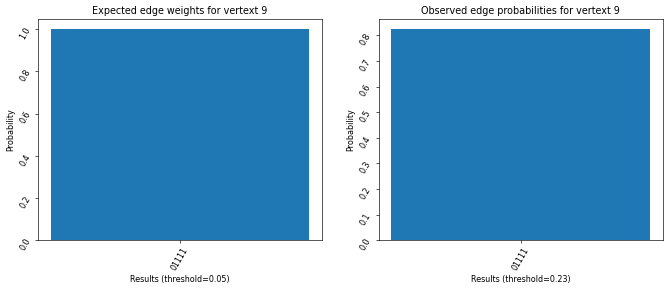

None

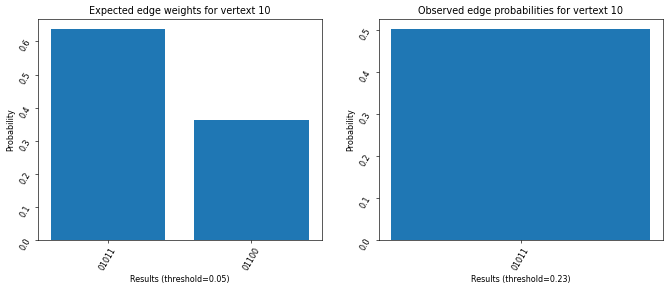

None

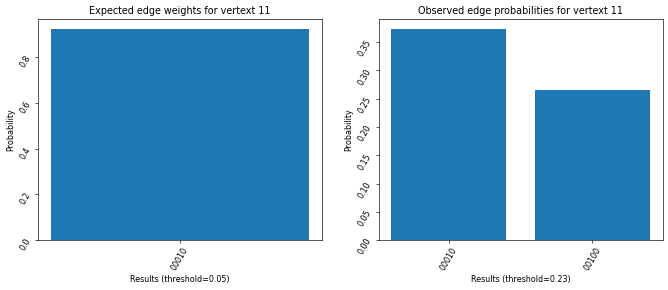

None

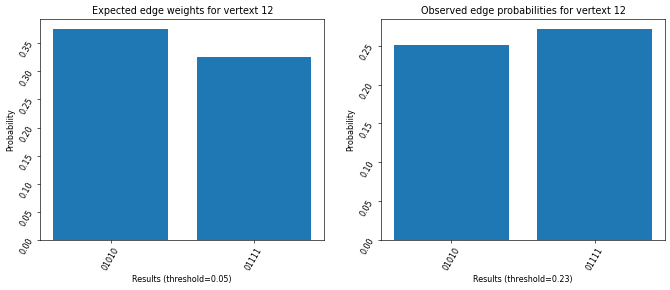

None

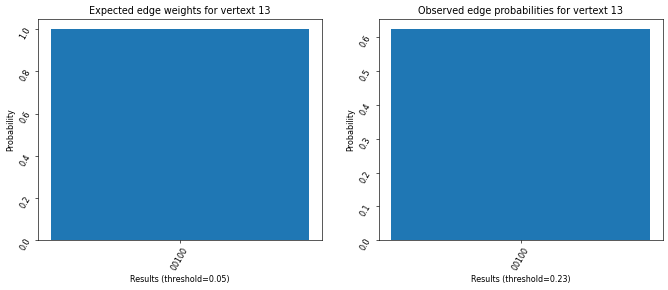

None

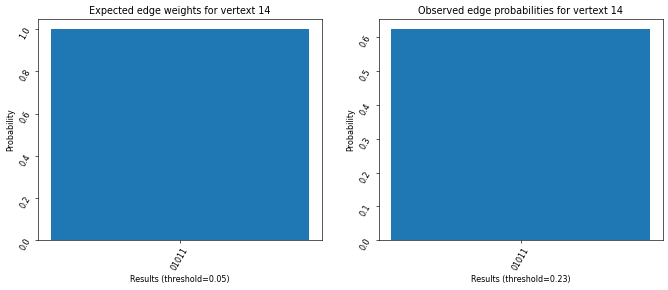

None

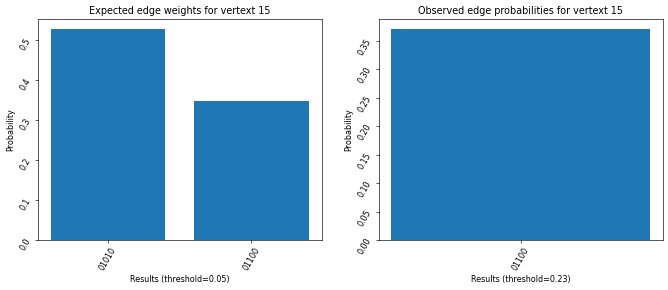

None

In [32]:
### Plots expected vs observed edge weight distribution
for r in range(opt_result.shape[0]):
    display(plot_compare_hist(expect[r], opt_result[r], scale=0.8, figsize=(14, 5), dpi=72, th=opt_thr, 
            title_1=f'Expected edge weights for vertext {r}', title_2=f'Observed edge probabilities for vertext {r}',
            xlabel_1=f'Results (threshold={thr})', xlabel_2=f'Results (threshold={opt_thr})'))

## Issues

**V1_08** Training
- Fixed 01 (240908) Model params not matching input - need to change the QG representation
  - Recoded QG representation, problem fixed
- Fixed 02 (240909) Error in classical and hybrid QG mode
  - That was a bad ref to NN layer in testing
- Fixed 03 (240909) QG accuracy calculated and compared
- Fixed 04 (240909) Need to apply KL and/or JS divergence as the loss function
  - Tested with JS, works well in quantum and hybrid mode
- Fixed 05 (240909) Poor QG performance
  - Performance improved in all modes, especially in hybrid mode with JSD<br/>
- Fixed 06 (240909) Math domain error in JSD when classic mode used<br/>
  - In classic mode, negative "Ps" were generated causing errors in log2, changed tests to include P > 0
  - A different error was generated, where the sum(results) <> 1, softmax was applied in forward and error fixed
- Fixed 07 (240909) Larger graph needs to be tested
  - Successfully used a graph with 16 nodes and 33 edges, which doubled the processing time (865 vs 404 secs)
- Fixed 08 (240909) Erroneous tensor generation after moving bit / list conversion to Circuits
  - As PennyLane was capturing numpy, a separate numpy_np was declared and error cleared
- Fixed 09 (240911) Compare side-by-side expected vs observed weight distributions
- Fixed 10 (240911) Fixed classic model with JSD by adding softmax, plus saves model performance and params to logs
- Fixed 11 (240912) Included side-by-side comparison of the expected vs observed weight distributions
- Fixed 12 (241219) Added several performance scores

## System

In [33]:
import sys
print(f'Environment:\n\n{sys.prefix}\n')

Environment:

/home/jacob/miniconda3/envs/pl-039



In [34]:
import os
print(f"Significant packages:\n")
os.system('pip list | grep -e torch -e PennyLane -e networkx');

Significant packages:

networkx                  3.4.2
PennyLane                 0.39.0
PennyLane_Lightning       0.39.0
torch                     2.5.1+cpu
torchaudio                2.5.1+cpu
torcheval                 0.0.7
torchvision               0.20.1+cpu
